# Part 2 - Views and Visualization

## Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sqlite3

## Function to retrieve Table

In [2]:
def retrieve_table(table_name: str, db: str):
    conn = sqlite3.connect(f"../{db}.db")
    c = conn.cursor()
    data = c.execute(f"""SELECT * FROM {table_name}""").fetchall()
    columns = c.execute(f"""PRAGMA table_info({table_name})""").fetchall()
    columns = [columns[i][1] for i in range(0, len(columns))]
    return pd.DataFrame(data, columns=columns)

## Create Views

### Common Functions

In [3]:
def drop_view(view_name: str, db: str):
    conn = sqlite3.connect(f"../{db}.db")
    c = conn.cursor()
    c.execute(f"DROP VIEW IF EXISTS {view_name}")

In [4]:
def add_view(query: str, view_name: str, db: str):
    conn = sqlite3.connect(f"../{db}.db")
    c = conn.cursor()
    c.execute(f"DROP VIEW IF EXISTS {view_name}")
    c.execute(f"""CREATE VIEW {view_name} AS {query}""")

In [5]:
def retrieve_query_pd(query: str, columns: list, db: str):
    conn = sqlite3.connect(f"../{db}.db")
    c = conn.cursor()
    data = c.execute(query)
    data = data.fetchall()
    return pd.DataFrame(data, columns=columns)

In [56]:
def plot_spotify_bar(df: str, y: list, width: list, title: str, xlabel: str, filename_to_save: str):
    
    fig, ax = plt.subplots(figsize = (10,9))
        
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    color=plt.get_cmap("viridis")(rescale(width))
    
    plt.barh(y = y, width = width, color = color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid(axis = 'x')
    plt.savefig(f'../views/{filename_to_save}.png', bbox_inches='tight')

def plot_spotify_time(df, time_col, y_col, title, ylabel, filename_to_save):
    fig, ax = plt.subplots(figsize = (10,4))
    df[time_col] = pd.to_datetime(df[time_col])
    plt.plot(df[time_col], df[y_col], marker='.', markersize=10, )
    plt.title(title)
    plt.ylabel(ylabel)
    plt.savefig(f'../views/{filename_to_save}.png', bbox_inches='tight')

### Top songs by artist in terms of duration_ms

In [8]:
query_top_10_songs_by_artist_by_duration = f"""
    WITH TOPTEN AS (SELECT artist.artist_name,
                          track.song_name,
                          track.duration_ms,
                          ROW_NUMBER() over (
                                PARTITION BY artist.artist_name
                                order by track.duration_ms DESC
                            ) AS RowNo 
                    FROM artist JOIN album ON artist.artist_id = album.artist_id
                        JOIN track ON album.album_id = track.album_id
                    )
    SELECT artist_name, song_name, duration_ms
    FROM TOPTEN WHERE RowNo <= 10;
    """


add_view(query_top_10_songs_by_artist_by_duration, 'top_10_songs_by_artist_by_duration', 'spotify')

In [9]:
retrieve_query_pd("SELECT * FROM top_10_songs_by_artist_by_duration",['artist_name','song_name','duration_ms'], 'spotify')



,artist_name,song_name,duration_ms
0,Adele,To Be Loved,403961
1,Adele,Love Is A Game,403044
2,Adele,My Little Love,389107
3,Adele,I Drink Wine,376169
4,Adele,Hold On,366004
...,...,...,...
195,Taylor Swift,evermore (feat. Bon Iver),304106
196,Taylor Swift,The Last Time (feat. Gary Lightbody of Snow Pa...,299080
197,Taylor Swift,Better Man (Taylor's Version) (From The Vault),297013
198,Taylor Swift,State Of Grace (Taylor's Version),295413


### Top artists in the database by # of followers

In [11]:
query_top_20_artists_by_followers = """SELECT artist_name, followers
                                        FROM artist
                                        ORDER BY 2 DESC"""

add_view(query_top_20_artists_by_followers, 'top_20_artists_by_followers', 'spotify')

In [12]:
retrieve_query_pd("SELECT * FROM top_20_artists_by_followers",['artist_name','followers'], 'spotify')

,artist_name,followers
0,Ed Sheeran,102633684
1,Billie Eilish,68972660
2,Taylor Swift,59039697
3,Bad Bunny,56281874
4,Queen,42806099
5,Adele,42464004
6,Coldplay,38618195
7,Maroon 5,37935016
8,Beyoncé,32184686
9,Shakira,25012014


### Top songs by artist in terms of tempo

In [14]:
query_top_10_songs_by_artist_by_tempo = """
    WITH TOPTEN AS (SELECT artist.artist_name,
                          track.song_name,
                          track_feature.tempo,
                          ROW_NUMBER() over (
                                PARTITION BY artist.artist_name
                                order by track_feature.tempo DESC
                            ) AS RowNo 
                    FROM artist JOIN album ON artist.artist_id = album.artist_id
                        JOIN track ON album.album_id = track.album_id
                        JOIN track_feature ON track.track_id = track_feature.track_id
                    )
    SELECT artist_name, song_name, tempo
    FROM TOPTEN WHERE RowNo <= 10;
    """


add_view(query_top_10_songs_by_artist_by_tempo, 'top_10_songs_by_artist_by_tempo', 'spotify')

In [15]:
retrieve_query_pd("SELECT * FROM top_10_songs_by_artist_by_tempo where artist_name = 'Taylor Swift'",['artist_name','song_name','tempo'], 'spotify')

,artist_name,song_name,tempo
0,Taylor Swift,State Of Grace (Acoustic Version) (Taylor's Ve...,208.918
1,Taylor Swift,Soon You’ll Get Better (feat. The Chicks),207.476
2,Taylor Swift,Untouchable (Taylor’s Version),200.391
3,Taylor Swift,All Too Well (Taylor's Version),185.972
4,Taylor Swift,White Horse (Taylor’s Version),185.262
5,Taylor Swift,ME! (feat. Brendon Urie of Panic! At The Disco),182.162
6,Taylor Swift,Getaway Car,172.054
7,Taylor Swift,We Are Never Ever Getting Back Together (Taylo...,172.014
8,Taylor Swift,Superstar (Taylor’s Version),171.862
9,Taylor Swift,champagne problems,171.346


### Top album for each artist by average song energy

In [17]:
query_top_1_album_by_artist_by_mean_song_energy = """
    WITH mean_energy as (SELECT artist.artist_name,
                          album.album_name,
                          AVG(track_feature.energy) as mean_energy
                    FROM artist JOIN album ON artist.artist_id = album.artist_id
                        JOIN track ON album.album_id = track.album_id
                        JOIN track_feature ON track.track_id = track_feature.track_id
                    GROUP BY 1, 2
                    ORDER BY 3 DESC),
    mean_energy_row_no AS (SELECT *, ROW_NUMBER() over (PARTITION BY artist_name
                                                        order by mean_energy DESC
                                                        ) AS RowNo
                            FROM mean_energy)
    SELECT artist_name, album_name, mean_energy
    FROM mean_energy_row_no WHERE RowNo <= 1;
    """


add_view(query_top_1_album_by_artist_by_mean_song_energy, 'top_1_album_by_artist_by_mean_song_energy', 'spotify')

In [18]:
retrieve_query_pd("SELECT * FROM top_1_album_by_artist_by_mean_song_energy",['artist_name','song_name','mean_energy'], 'spotify')

,artist_name,song_name,mean_energy
0,Adele,21,0.534000
1,Bad Bunny,OASIS,0.758000
2,Beyoncé,Above And Beyoncé Dance Mixes,0.724625
3,Billie Eilish,Happier Than Ever,0.313562
4,Britney Spears,Britney (Digital Deluxe Version),0.810200
5,Camilo,Mis Manos,0.618727
6,Coldplay,Viva La Vida or Death and All His Friends,0.657900
7,Eagles,On the Border (2013 Remaster),0.645200
8,Ed Sheeran,No.5 Collaborations Project,0.705125
9,Enrique Iglesias,Euphoria (Standard US/Latin version),0.828700


### Albums without explicit songs

In [ ]:
query_albums_without_explicit_songs = """
    WITH explicit_ind AS (SELECT track_id,
                                album_id,
                                (CASE WHEN upper(track.explicit) = "FALSE" THEN 0 ELSE 1 END) as explicit
                            FROM track)

    SELECT artist.artist_name, 
            album.album_name
    FROM artist JOIN album ON artist.artist_id = album.artist_id
        JOIN explicit_ind ON album.album_id = explicit_ind.album_id
        JOIN track_feature ON explicit_ind.track_id = track_feature.track_id
    GROUP BY 1, 2
    HAVING SUM(explicit_ind.explicit) = 0
    """


In [ ]:
add_view(query_albums_without_explicit_songs, 'albums_without_explicit_songs', 'spotify')

In [22]:
retrieve_query_pd("SELECT * FROM albums_without_explicit_songs",['artist_name','album_name'], 'spotify')

,artist_name,album_name
0,Adele,25
1,Adele,30
2,Bad Bunny,OASIS
3,Beyoncé,4
4,Beyoncé,Above And Beyoncé Dance Mixes
...,...,...
100,Taylor Swift,Lover
101,Taylor Swift,Red (Taylor's Version)
102,Taylor Swift,evermore
103,Taylor Swift,folklore


## Data Visualizations

### Longest Songs by Artist

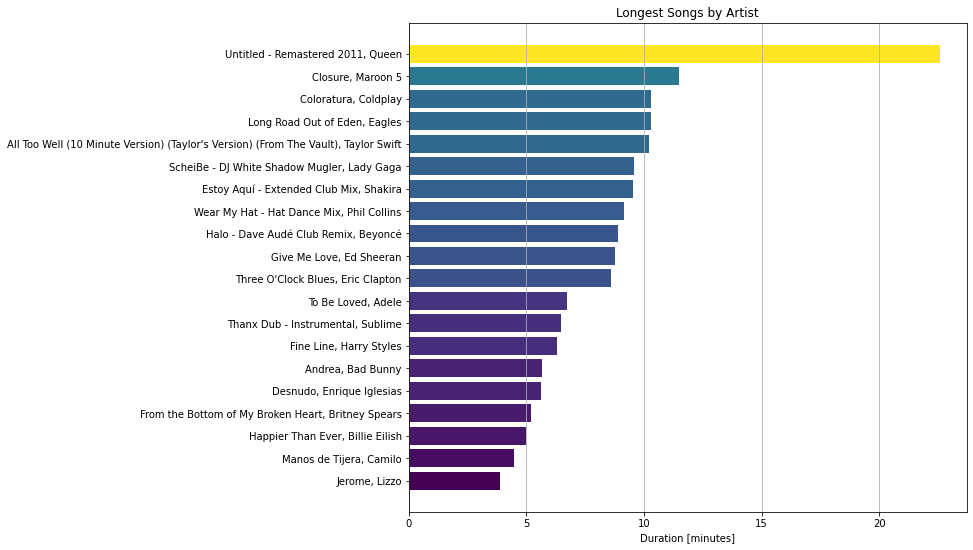

In [23]:
longest_songs_by_artist = retrieve_query_pd("""SELECT artist_name,
                            song_name,
                            MAX(duration_ms) as duration_ms
                      FROM top_10_songs_by_artist_by_duration GROUP BY 1
                      ORDER BY 3;""",
                  ['artist_name','song_name','duration_ms'], 'spotify')
plot_spotify_bar(longest_songs_by_artist, 
                 y = [', '.join(longest_songs_by_artist.loc[i,['song_name','artist_name']]) for i in longest_songs_by_artist[['artist_name','song_name']].index],
                 width = longest_songs_by_artist['duration_ms']/(1000*60), 
                 title = 'Longest Songs by Artist',
                 xlabel = 'Duration [minutes]',
                 filename_to_save = 'top_songs_by_artist_by_duration')

### Highest Energy Albums by Artist

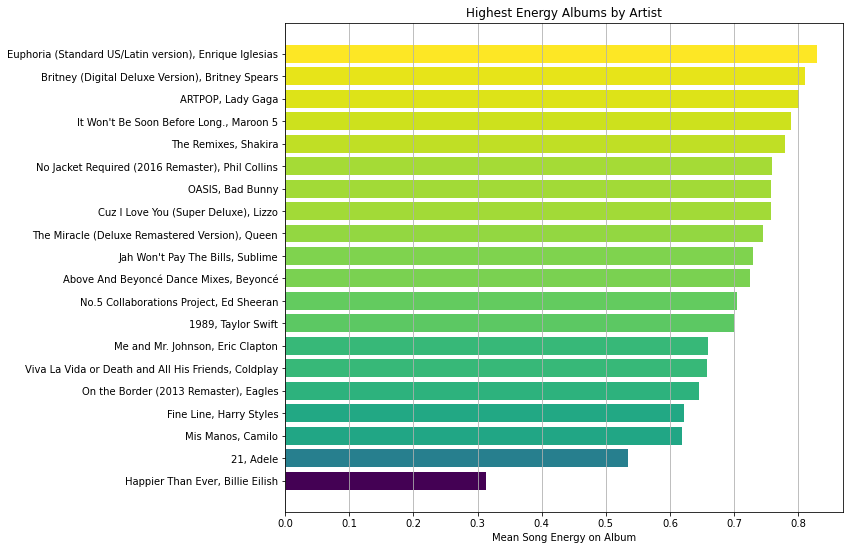

In [24]:
highest_energy_by_artist = retrieve_query_pd("""SELECT artist_name,
                            album_name,
                            mean_energy
                      FROM top_1_album_by_artist_by_mean_song_energy
                      ORDER BY 3;""",
                  ['artist_name','album_name','mean_energy'], 'spotify')
plot_spotify_bar(longest_songs_by_artist, 
                 y = [', '.join(highest_energy_by_artist.loc[i,['album_name','artist_name']]) for i in longest_songs_by_artist[['artist_name','song_name']].index],
                 width = highest_energy_by_artist['mean_energy'], 
                 title = 'Highest Energy Albums by Artist',
                 xlabel = 'Mean Song Energy on Album',
                 filename_to_save = 'top_1_album_by_artist_by_mean_song_energy')

### Mean Album Energy by Taylor Swift

In [25]:
lady_gaga_albums_by_mean_song_energy = retrieve_query_pd("""
    WITH mean_energy as (SELECT artist.artist_name,
                          album.album_name,
                          album.release_date,
                          AVG(track_feature.energy) as mean_energy
                    FROM artist JOIN album ON artist.artist_id = album.artist_id
                        JOIN track ON album.album_id = track.album_id
                        JOIN track_feature ON track.track_id = track_feature.track_id
                    GROUP BY 1, 2
                    ORDER BY 3 DESC)
    SELECT artist_name, album_name, release_date, mean_energy
    FROM mean_energy
    WHERE artist_name = "Lady Gaga"
    ORDER BY release_date;
    """,
                  ['artist_name','album_name','release_date','mean_energy'], 'spotify')


In [26]:
lady_gaga_albums_by_mean_song_energy.sort_values('release_date')

,artist_name,album_name,release_date,mean_energy
0,Lady Gaga,The Fame Monster (Deluxe Edition),2009-11-05,0.774000
1,Lady Gaga,Born This Way (Special Edition),2011-01-01,0.796591
2,Lady Gaga,ARTPOP,2013-11-11,0.801143
3,Lady Gaga,Cheek To Cheek (Deluxe),2014-09-23,0.429667
4,Lady Gaga,Joanne (Deluxe),2016-10-21,0.579000
5,Lady Gaga,A Star Is Born Soundtrack (Without Dialogue),2018-10-05,0.511316
6,Lady Gaga,Chromatica,2020-05-29,0.760750
7,Lady Gaga,Love For Sale (Deluxe),2021-10-01,0.465667
8,Lady Gaga,Top Gun: Maverick (Music From The Motion Picture),2022-05-27,0.408892


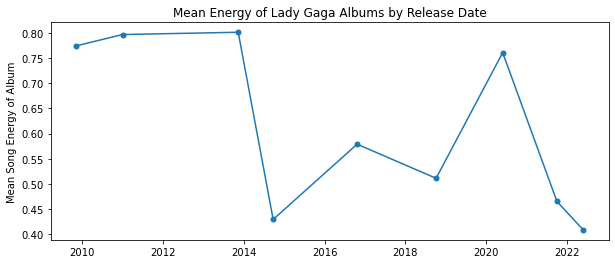

In [57]:
plot_spotify_time(lady_gaga_albums_by_mean_song_energy, 'release_date','mean_energy','Mean Energy of Lady Gaga Albums by Release Date','Mean Song Energy of Album','lady_gaga_albums_by_mean_song_energy_over_time')


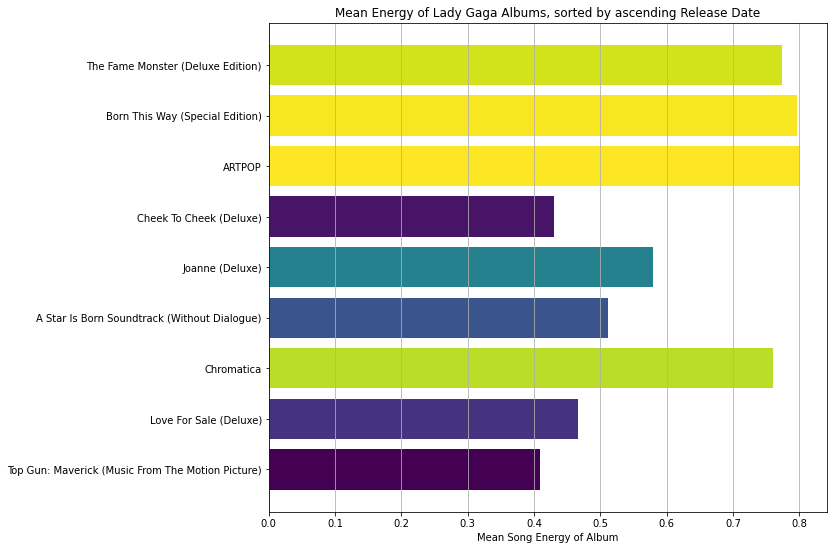

In [58]:
df = lady_gaga_albums_by_mean_song_energy.sort_values('release_date',ascending=False)
plot_spotify_bar(df, df['album_name'], df['mean_energy'], 'Mean Energy of Lady Gaga Albums, sorted by ascending Release Date', 'Mean Song Energy of Album', 'lady_gaga_albums_by_mean_song_energy')


In [30]:
#plt.plot(lady_gaga_albums_by_mean_song_energy['release_date','mean_energy']

## Merge tables into songs dataframe

In [3]:
sql_tables = {}
for table_name in ['artist','album','track','track_feature']:
    sql_tables[table_name] = retrieve_table(table_name, "spotify")

In [10]:
retrieve_query_pd('PRAGMA table_info(track_feature)',range(6),'spotify')

,0,1,2,3,4,5
0,0,track_id,TEXT,0,None,0
1,1,danceability,REAL,0,None,0
2,2,energy,REAL,0,None,0
3,3,instrumentalness,REAL,0,None,0
4,4,liveness,REAL,0,None,0
5,5,loudness,REAL,0,None,0
6,6,speechiness,REAL,0,None,0
7,7,tempo,REAL,0,None,0
8,8,type,TEXT,0,None,0
9,9,valence,REAL,0,None,0


In [33]:
songs = pd.merge(sql_tables['track_feature'], sql_tables['track'], on="track_id", how="outer", suffixes=('_feature','_track'))

songs = pd.merge(songs, sql_tables['album'], on="album_id", how="outer",suffixes=('_track','_album'))

songs = pd.merge(songs, sql_tables['artist'], on="artist_id", how="outer",suffixes=('_album','_artist'))

In [34]:
songs.query('artist_name == "Queen"').sort_values('duration_ms')[['song_name','album_name','duration_ms']]

,song_name,album_name,duration_ms
186,Yeah - Remastered 2011,Made in Heaven (Deluxe Remastered Version),4066
161,Chinese Torture - Instrumental,The Miracle (Deluxe Remastered Version),104400
128,Is This The World We Created...? - Remastered ...,The Works (Deluxe Remastered Version),134293
146,Party - Remastered 2011,The Miracle (Deluxe Remastered Version),144893
175,It's A Beautiful Day - Remastered 2011,Made in Heaven (Deluxe Remastered Version),154066
...,...,...,...
120,Radio Ga Ga - Remastered 2011,The Works (Deluxe Remastered Version),348226
118,Action This Day - Live In Tokyo / November 1982,Hot Space (Deluxe Remastered Version),385600
145,One Vision,A Kind Of Magic,388466
163,Innuendo,Innuendo,391266


In [35]:
songs.query('artist_name == "Queen"').album_name.unique()

array(['Hot Space (Deluxe Remastered Version)',
       'The Works (Deluxe Remastered Version)', 'A Kind Of Magic',
       'The Miracle (Deluxe Remastered Version)', 'Innuendo',
       'Made in Heaven (Deluxe Remastered Version)'], dtype=object)

In [36]:
songs.query('album_name == "Queen On Air"')[['song_name','album_name']]

,song_name,album_name


In [37]:
songs.query('artist_name == "Queen"')[['song_name','album_name']]

,song_name,album_name
104,Staying Power - Remastered 2011,Hot Space (Deluxe Remastered Version)
105,Dancer - Remastered 2011,Hot Space (Deluxe Remastered Version)
106,Back Chat - Remastered 2011,Hot Space (Deluxe Remastered Version)
107,Body Language - Remastered 2011,Hot Space (Deluxe Remastered Version)
108,Action This Day - Remastered 2011,Hot Space (Deluxe Remastered Version)
...,...,...
189,It's A Beautiful Day - B-Side Version / Remast...,Made in Heaven (Deluxe Remastered Version)
190,My Life Has Been Saved - 1989 B-Side Version /...,Made in Heaven (Deluxe Remastered Version)
191,I Was Born To Love You - Vocals & Piano Versio...,Made in Heaven (Deluxe Remastered Version)
192,Rock In Rio Blues - Live / B-Side / Remastered...,Made in Heaven (Deluxe Remastered Version)


In [38]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1927 entries, 0 to 1926
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   track_id            1927 non-null   object 
 1   danceability        1927 non-null   float64
 2   energy              1927 non-null   float64
 3   instrumentalness    1927 non-null   float64
 4   liveness            1927 non-null   float64
 5   loudness            1927 non-null   float64
 6   speechiness         1927 non-null   float64
 7   tempo               1927 non-null   float64
 8   type_feature        1927 non-null   object 
 9   valence             1927 non-null   float64
 10  song_uri_feature    1927 non-null   object 
 11  song_name           1927 non-null   object 
 12  external_url_track  1927 non-null   object 
 13  duration_ms         1927 non-null   int64  
 14  explicit            1927 non-null   object 
 15  disc_number         1927 non-null   int64  
 16  type_t

In [39]:
# A kind of magic
# BORN THIS WAY THE TENTH ANNIVERSARY
# HOMECOMING: THE LIVE ALBUM
# 'I Am...World Tour'
# Shakira MTV Unplugged
sql_tables['album'].album_name.sort_values().values

array(['+', '...Baby One More Time (Digital Deluxe Version)', '19',
       '1989', '21', '25', '30', '4', '40oz. To Freedom', '7', '=',
       'A Head Full of Dreams', 'A Kind Of Magic',
       'A Rush of Blood to the Head',
       'A Star Is Born Soundtrack (Without Dialogue)', 'ARTPOP',
       'Above And Beyoncé Dance Mixes', "B'Day",
       'BEYONCÉ [Platinum Edition]', 'Back Home', 'Blackout',
       'Born This Way (Special Edition)', 'Both Sides (2015 Remaster)',
       'Britney (Digital Deluxe Version)', 'Brother Bear',
       'Call And Response: The Remix Album', 'Cheek To Cheek (Deluxe)',
       'Chromatica', 'Circus (Deluxe Version)', 'Clapton',
       'Cosas Del Amor', 'Cuz I Love You (Super Deluxe)',
       'Dance into the Light (2016 Remaster)', 'Dangerously In Love',
       'De Adentro Pa Afuera', 'Desperado (2013 Remaster)',
       'Donde Estan Los Ladrones', 'Eagles (2013 Remaster)', 'El Dorado',
       'Enrique Iglesias', 'Escape',
       'Euphoria (Standard US/Latin ve

In [40]:
album_table = sql_tables['album']